In [ ]:
#Preprocessing Pandas

In [2]:
import pandas as pd
sample_submission = pd.read_csv("understanding_cloud_organization/sample_submission.csv")
train = pd.read_csv("understanding_cloud_organization/train.csv")

In [3]:
train['Image_name'] = train['Image_Label'].apply(lambda x: x.split('_')[0])
train['Label_name'] = train['Image_Label'].apply(lambda x: x.split('_')[1])
train.drop('Image_Label',axis=1,inplace=True)
train = train.pivot('Image_name','Label_name','EncodedPixels')

In [4]:
train.head()

Label_name,Fish,Flower,Gravel,Sugar
Image_name,,,,
0011165.jpg,264918 937 266318 937 267718 937 269118 937 27...,1355565 1002 1356965 1002 1358365 1002 1359765...,NaN,NaN
002be4f.jpg,233813 878 235213 878 236613 878 238010 881 23...,1339279 519 1340679 519 1342079 519 1343479 51...,NaN,67495 350 68895 350 70295 350 71695 350 73095 ...
0031ae9.jpg,3510 690 4910 690 6310 690 7710 690 9110 690 1...,2047 703 3447 703 4847 703 6247 703 7647 703 9...,NaN,658170 388 659570 388 660970 388 662370 388 66...
0035239.jpg,NaN,100812 462 102212 462 103612 462 105012 462 10...,65400 380 66800 380 68200 380 69600 380 71000 ...,NaN
003994e.jpg,2367966 18 2367985 2 2367993 8 2368002 62 2369...,NaN,353317 416 354717 416 356117 416 357517 416 35...,28011 489 29411 489 30811 489 32211 489 33611 ...


In [1]:
# Affichage Image

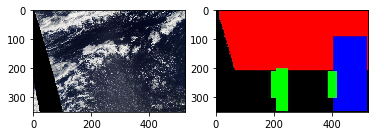

In [11]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

img=mpimg.imread('./understanding_cloud_organization/train_images_350/009e2f3.jpg')
img2=mpimg.imread('./understanding_cloud_organization/train_images_350_Black_Fish_Gravel_Sugar_Flower/009e2f3.jpg')

f, axarr = plt.subplots(1,2)
axarr[0].imshow(img)
axarr[1].imshow(img2)



In [ ]:
# DATA LOADING

In [6]:
from transformations import Compose, Resize, DenseTarget
from transformations import MoveAxis, Normalize01
from customdatasets import SegmentationDataSet
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
import pathlib

# root directory
root = pathlib.Path.cwd() / 'understanding_cloud_organization'
def get_filenames_of_path(path: pathlib.Path, ext: str = '*'):
    """Returns a list of files in a directory/path. Uses pathlib."""
    filenames = [file for file in path.glob(ext) if file.is_file()]
    return filenames

# input and target files
inputs = get_filenames_of_path(root / 'train_images_350')
targets = get_filenames_of_path(root / 'train_images_350_Black_Fish_Gravel_Sugar_Flower')

# training transformations and augmentations
transforms = Compose([
    DenseTarget(),
    MoveAxis(),
    Normalize01()
])

# random seed
random_seed = 42

# split dataset into training set and validation set
train_size = 0.8  # 80:20 split

inputs_train, inputs_valid = train_test_split(
    inputs,
    random_state=random_seed,
    train_size=train_size,
    shuffle=True)

targets_train, targets_valid = train_test_split(
    targets,
    random_state=random_seed,
    train_size=train_size,
    shuffle=True)

# dataset training
dataset_train = SegmentationDataSet(inputs=inputs_train,
                                    targets=targets_train,
                                    transform=None)

# dataset validation
dataset_valid = SegmentationDataSet(inputs=inputs_valid,
                                    targets=targets_valid,
                                    transform=None)

# dataloader training
dataloader_training = DataLoader(dataset=dataset_train,
                                 batch_size=2,
                                 shuffle=False)
print(next(iter(dataloader_training)))
# dataloader validation
dataloader_validation = DataLoader(dataset=dataset_valid,
                                   batch_size=2,
                                   shuffle=False)



/usr/lib/python3/dist-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


[tensor([[[[ 49.,  58.,  67.],
          [ 40.,  48.,  59.],
          [ 91.,  98., 116.],
          ...,
          [  8.,  19.,  49.],
          [  7.,  18.,  48.],
          [  7.,  18.,  48.]],

         [[ 25.,  32.,  50.],
          [ 14.,  21.,  40.],
          [ 16.,  22.,  44.],
          ...,
          [  8.,  19.,  49.],
          [  8.,  19.,  49.],
          [  8.,  19.,  49.]],

         [[ 13.,  20.,  48.],
          [ 20.,  27.,  55.],
          [  6.,  13.,  39.],
          ...,
          [  8.,  19.,  49.],
          [  9.,  20.,  50.],
          [  9.,  20.,  50.]],

         ...,

         [[ 85.,  90., 109.],
          [ 51.,  56.,  75.],
          [ 31.,  36.,  55.],
          ...,
          [ 13.,  17.,  46.],
          [ 32.,  36.,  65.],
          [101., 105., 130.]],

         [[ 43.,  49.,  65.],
          [ 16.,  21.,  40.],
          [ 39.,  44.,  63.],
          ...,
          [ 20.,  21.,  52.],
          [ 26.,  27.,  57.],
          [ 59.,  60.,  88.]],


In [7]:
x, y = next(iter(dataloader_training))

print(f'x = shape: {x.shape}; type: {x.dtype}')
print(f'x = min: {x.min()}; max: {x.max()}')
print(f'y = shape: {y.shape}; class: {y.unique()}; type: {y.dtype}')


x = shape: torch.Size([2, 350, 525, 3]); type: torch.float32
x = min: 0.0; max: 255.0
y = shape: torch.Size([2, 350, 525, 3]); class: tensor([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
         14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,
         28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,
         42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,
         56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,
         70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,
         84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,
         98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111,
        112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125,
        126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139,
        140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153,
        

In [ ]:
## MODEL UNET

In [10]:
import torch
from unet import *
model = UNet(in_channels=1,
             out_channels=4,
             n_blocks=2,
             start_filters=32,
             activation='relu',
             normalization='batch',
             conv_mode='same',
             dim=2).cuda()
x = torch.randn(size=(1, 1, 512, 512), dtype=torch.float32).cuda()
with torch.no_grad():
    out = model(x)

print(f'Out: {out.shape}')

Out: torch.Size([1, 4, 512, 512])


In [11]:
from torchsummary import summary
summary = summary(model, (1, 512, 512))



----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 512, 512]             320
              ReLU-2         [-1, 32, 512, 512]               0
       BatchNorm2d-3         [-1, 32, 512, 512]              64
            Conv2d-4         [-1, 32, 512, 512]           9,248
              ReLU-5         [-1, 32, 512, 512]               0
       BatchNorm2d-6         [-1, 32, 512, 512]              64
         MaxPool2d-7         [-1, 32, 256, 256]               0
         DownBlock-8  [[-1, 32, 256, 256], [-1, 32, 512, 512]]               0
            Conv2d-9         [-1, 64, 256, 256]          18,496
             ReLU-10         [-1, 64, 256, 256]               0
      BatchNorm2d-11         [-1, 64, 256, 256]             128
           Conv2d-12         [-1, 64, 256, 256]          36,928
             ReLU-13         [-1, 64, 256, 256]               0
      BatchNorm2d-14    

In [12]:
shape = 1920


def compute_max_depth(shape, max_depth=10, print_out=True):
    shapes = []
    shapes.append(shape)
    for level in range(1, max_depth):
        if shape % 2 ** level == 0 and shape / 2 ** level > 1:
            shapes.append(shape / 2 ** level)
            if print_out:
                print(f'Level {level}: {shape / 2 ** level}')
        else:
            if print_out:
                print(f'Max-level: {level - 1}')
            break

    return shapes


out = compute_max_depth(shape, print_out=True, max_depth=10)


Level 1: 960.0
Level 2: 480.0
Level 3: 240.0
Level 4: 120.0
Level 5: 60.0
Level 6: 30.0
Level 7: 15.0
Max-level: 7


In [13]:
low = 10
high = 512
depth = 8


def compute_possible_shapes(low, high, depth):
    possible_shapes = {}
    for shape in range(low, high + 1):
        shapes = compute_max_depth(shape,
                                   max_depth=depth,
                                   print_out=False)
        if len(shapes) == depth:
            possible_shapes[shape] = shapes

    return possible_shapes
possible_shapes = compute_possible_shapes(low, high, depth)
possible_shapes


{256: [256, 128.0, 64.0, 32.0, 16.0, 8.0, 4.0, 2.0],
 384: [384, 192.0, 96.0, 48.0, 24.0, 12.0, 6.0, 3.0],
 512: [512, 256.0, 128.0, 64.0, 32.0, 16.0, 8.0, 4.0]}

In [ ]:
#TRAIN ET RUN

In [14]:
from train import Trainer

# device
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    torch.device('cpu')

# criterion
criterion = torch.nn.CrossEntropyLoss()

# optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

# trainer
trainer = Trainer(model=model,
                  device=device,
                  criterion=criterion,
                  optimizer=optimizer,
                  training_DataLoader=dataloader_training,
                  validation_DataLoader=dataloader_validation,
                  lr_scheduler=None,
                  epochs=4,
                  epoch=0,
                  notebook=True)

# start training
training_losses, validation_losses, lr_rates = trainer.run_trainer()


RuntimeError: Given groups=1, weight of size [32, 1, 3, 3], expected input[2, 350, 525, 3] to have 1 channels, but got 350 channels instead

In [ ]:
# SAVE THE MODEL

In [ ]:
model_name =  'cloud.pt'
torch.save(model.state_dict(), pathlib.Path.cwd() / model_name)

In [ ]:
# LEARNING RATE

In [ ]:
from lr_rate_finder import *
lrf = LearningRateFinder(model, criterion, optimizer, device)
lrf.fit(dataloader_training, steps=1000)

In [ ]:
lrf.plot()


In [ ]:
from visual import plot_training
fig = plot_training(training_losses, validation_losses, lr_rates, gaussian=True, sigma=1, figsize=(10, 4))